In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np

pd.set_option("display.max_rows", 10, "display.max_columns", None)


In [4]:
febMar20 = pd.read_csv('Simmer_FebMar20.csv', low_memory=False)
decJan19 = pd.read_csv('Simmer_DecJan19.csv', low_memory=False)
augSep19 = pd.read_csv('Simmer_AugSep19.csv', low_memory=False)
octNov19 = pd.read_csv('Simmer_OctNov19.csv', low_memory=False)
peopleDF = pd.read_csv('People_Sample.csv', low_memory=False)

In [5]:
nullCountsAugSep = pd.DataFrame({'Column Name': augSep19.columns, 'Null Count' : [augSep19[column].isnull().sum() for column in augSep19.columns]})
nullCountsDecJan = pd.DataFrame({'Column Name': decJan19.columns, 'Null Count' : [decJan19[column].isnull().sum() for column in decJan19.columns]})
nullCountsFebMar = pd.DataFrame({'Column Name': febMar20.columns, 'Null Count' : [febMar20[column].isnull().sum() for column in febMar20.columns]})
nullCountsOctNov = pd.DataFrame({'Column Name': octNov19.columns, 'Null Count': [octNov19[column].isnull().sum() for column in octNov19.columns]})
nullCountsAugSep[nullCountsAugSep['Null Count'] < 0.3 * len(augSep19)]
nullCountsDecJan[nullCountsDecJan['Null Count'] < .3 * len(decJan19)]
nullCountsFebMar[nullCountsFebMar['Null Count'] < .2 * len(febMar20)]
nullCountsOctNov[nullCountsOctNov['Null Count'] < .3 * len(octNov19)]

,Column Name,Null Count
0,name,0
1,distinct_id,0
2,time,0
3,sampling_factor,0
4,dataset,0
...,...,...
27,properties.UUId,2227
28,properties.mp_country_code,1042
29,properties.mp_device_model,2461
30,properties.mp_lib,1050


In [6]:
final_selected_columns = ['name',
 'distinct_id',
 'time',
 'properties.$ae_session_length',
 'properties.$city',
 'properties.$region',
 'properties.mp_country_code',
 'properties.locationSetting',
 'properties.notificationSettings',
 'properties.FirstTimeUploaded',
 'properties.$had_persisted_distinct_id',
 'properties.Signup With',
 'properties.imageAdded',
 'properties.commentAdded',
 'properties.commentLength',
 'properties.ImageUploaded']

In [7]:
columns_values = {}
df_list = [febMar20, decJan19, octNov19, augSep19]
selected_columns = final_selected_columns
for column in selected_columns:
    for df in df_list:
        if column in columns_values:
            columns_values[column] += list(df[column])
        else:
            columns_values[column] = []
            columns_values[column] += list(df[column])

past7Months = pd.DataFrame(columns_values)

In [8]:
past7Months['properties.ImageUploaded']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
190366    NaN
190367    NaN
190368    NaN
190369    NaN
190370    NaN
Name: properties.ImageUploaded, Length: 190371, dtype: object

## 

In [9]:
past7Months['properties.$region'].value_counts()

California                    41886
Gujarat                       25055
Illinois                      17403
New York                      14434
District of Columbia          12427
                              ...  
Colombo District                  1
Provincia de Santo Domingo        1
Marne                             1
Haringey                          1
Cluj                              1
Name: properties.$region, Length: 253, dtype: int64

<BarContainer object of 4 artists>

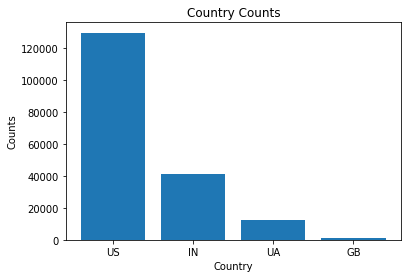

In [10]:
series = past7Months['properties.mp_country_code'].value_counts()
region = series[series > 1000] #More than 1000 records of country_code

plt.title('Country Counts')
plt.xlabel('Country')
plt.ylabel('Counts')
plt.bar(region.index, region.values)

In [11]:
series = past7Months['distinct_id'].value_counts()
series[series > 30]

nb@gmail.com_93                         18347
4E1A70A0-C2DB-46EB-A9C8-B4F0B0815771    12049
richard.z.wu@gmail.com_136               6437
vaibhavverma9@uchicago.edu_56            5482
ab.codebase@gmail.com_52                 3474
                                        ...  
2381BB3D-2198-432D-824F-A1C9F6FA1DFF       31
07A66A8D-FF70-4E45-AEFD-5FB7B5DB966A       31
47A8F015-3628-4D88-9246-9A6301EAAC67       31
153ECFD8-68E8-49B4-95B5-AD6B4205138A       31
A57AD532-72A0-46A5-82EE-368B797D1689       31
Name: distinct_id, Length: 971, dtype: int64

In [12]:
def filter_nan(df, threshold):
    length = len(df)
    result = pd.DataFrame()
    for col in df.columns:
        if (df[col].isnull().sum() < length * threshold):
            result[col] = df[col]
    return result

In [13]:
def clean_people(people_data, features):
    people_data = filter_nan(people_data, 0.5)
    people_data = people_data.loc[:, features]
    people_data.rename(columns=lambda x: re.sub('properties.|\$','',x), inplace=True)
    people_data.rename(columns={'Name' : 'name', 'AuthProvider' : 'auth_provider'}, inplace=True)
    people_data['name'].fillna('Unknown', inplace=True)
    people_data['city'].fillna('Unknown', inplace=True)
    people_data['region'].fillna('Unknown', inplace=True)
    people_data['auth_provider'].fillna('Unknown', inplace=True)
    people_data['ae_first_app_open_date'] = pd.to_datetime(people_data['ae_first_app_open_date'])
    people_data['last_seen'] = pd.to_datetime(people_data['last_seen'])
    #add a column for time between first and last session
    people_data['active_timespan'] = people_data['last_seen'] - people_data['ae_first_app_open_date']
    people_data['average_session_time'] = people_data['ae_total_app_session_length']/people_data['ae_total_app_sessions']
    return people_data



In [14]:
# past7Months[past7Months['distinct_id'] == 'Dzavala@uchicago.edu_118'].sort_values(by='time')
# past7Months[['properties.ImageUploaded']][-past7Months['properties.ImageAdded'].isnull()]['properties.ImageAdded'].value_counts()

In [15]:
selected_people_features = ['distinct_id', 
'properties.$ae_total_app_session_length', 
'properties.Name',
'properties.$region',
'properties.$country_code',
'properties.$city',
'properties.AuthProvider',
'properties.$ae_total_app_sessions',
'properties.$timezone',
'properties.$last_seen',
'properties.$ios_app_version',
'properties.$ios_version',
'properties.$ios_device_model',
'properties.$ios_lib_version',
'properties.$ae_first_app_open_date'
]

In [16]:
people_cleaned = clean_people(peopleDF, selected_people_features)
people_cleaned.drop('region', axis=1, inplace=True)
people_cleaned.drop('city', axis=1, inplace=True)

In [17]:
people_events = past7Months.merge(people_cleaned, how='left', on='distinct_id')
people_events

,name_x,distinct_id,time,properties.$ae_session_length,properties.$city,properties.$region,properties.mp_country_code,properties.locationSetting,properties.notificationSettings,properties.FirstTimeUploaded,properties.$had_persisted_distinct_id,properties.Signup With,properties.imageAdded,properties.commentAdded,properties.commentLength,properties.ImageUploaded,ae_total_app_session_length,name_y,country_code,auth_provider,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time
0,$ae_session,fac4dd756360cc15,1582560733000,20.3,San Francisco,California,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
1,AppOpen,fac4dd756360cc15,1582560712000,NaN,San Francisco,California,US,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
2,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524264000,12.8,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3,$ae_session,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524376000,106.3,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
4,AppOpen,B16482B3-A3CD-4A27-B579-34F79CC47396,1583524243000,NaN,Hyattsville,Maryland,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787552000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190367,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787554000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190368,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787555000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
190369,Onboarding - Allow Location,A8E48126-0505-4560-AF2E-58720466A847,1569787559000,NaN,Milpitas,California,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN


In [18]:
def clean_event(event_data, features):
    event_data = event_data.loc[:, features]
    event_data.rename(columns=lambda x: re.sub('properties.|\$','',x), inplace=True)
    return event_data

In [19]:
people_events = clean_event(people_events, people_events.columns)

In [20]:
people_events['time'] = people_events['time'].astype(int)


In [21]:
data_test = people_events[['name_x','commentLength']][-people_events['commentLength'].isnull()]

In [22]:
people_events[-people_events['ImageUploaded'].isnull()]

,name_x,distinct_id,time,ae_session_length,city,region,mp_country_code,locationSetting,notificationSettings,FirstTimeUploaded,had_persisted_distinct_id,Signup With,imageAdded,commentAdded,commentLength,ImageUploaded,ae_total_app_session_length,name_y,country_code,auth_provider,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time
3108,Item Page - Tap Upload Photo,FCF89FCA-EF91-41FD-BBAE-E618D35C83B3,1581269829000,NaN,Centreville,Virginia,US,NaN,NaN,False,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
3109,Item Page - Tap Upload Photo,FCF89FCA-EF91-41FD-BBAE-E618D35C83B3,1581269834000,NaN,Centreville,Virginia,US,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
6974,Item Page - Tap Upload Photo,F3ACF717-1FF0-42D6-9B87-93A534B0DB80,1581746176000,NaN,Troy,Michigan,US,NaN,NaN,False,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
7086,Item Page - Tap Upload Photo,F1ED6532-1BE7-4FCD-9E67-12621B03E171,1580668970000,NaN,San Francisco,California,US,NaN,NaN,False,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
7894,Item Page - Tap Upload Photo,0BC21542-59E3-4107-AB10-ABFCFF6393B6,1585148055000,NaN,New York,New York,US,NaN,NaN,False,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187948,Item Page - Tap Upload Photo,vaibhavverma9@uchicago.edu_56,1568912028000,NaN,San Francisco,California,US,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,213277.0,Vaibhav Verma,US,Facebook,2621.0,America/Los_Angeles,2020-03-26 18:31:32+00:00,2.5.7,13.3,"iPhone10,3",3.4.9,NaT,NaT,81.372377
187949,Item Page - Tap Upload Photo,vaibhavverma9@uchicago.edu_56,1568912069000,NaN,San Francisco,California,US,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,213277.0,Vaibhav Verma,US,Facebook,2621.0,America/Los_Angeles,2020-03-26 18:31:32+00:00,2.5.7,13.3,"iPhone10,3",3.4.9,NaT,NaT,81.372377
188982,Item Page - Tap Upload Photo,eemilyshenn@gmail.com_227,1565118831000,NaN,Chicago,Illinois,US,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,109558.0,Emily Shen,US,Facebook,1106.0,America/Chicago,2020-01-27 14:05:35+00:00,2.4.0,13.3,"iPhone10,1",3.4.4,NaT,NaT,99.057866
190016,Item Page - Tap Upload Photo,eemilyshenn@gmail.com_227,1568107313000,NaN,Chicago,Illinois,US,NaN,NaN,True,True,NaN,NaN,NaN,NaN,True,109558.0,Emily Shen,US,Facebook,1106.0,America/Chicago,2020-01-27 14:05:35+00:00,2.4.0,13.3,"iPhone10,1",3.4.4,NaT,NaT,99.057866


## Grace Changes

In [23]:
people_events['time'] = [datetime.fromtimestamp(i / 1000.0).strftime('%Y-%m-%d %H:%M:%S.%f') for i in people_events['time']]

In [24]:
people_events = people_events.sort_values('distinct_id').sort_values('time').reset_index(drop=True)

In [25]:
#user_events[user_events['name_x'] != '$ae_session']
people_events['country'] = people_events['mp_country_code'].apply(lambda x: 'NA' if not isinstance(x, str) else 'US' if x == 'US' else 'INTL')
people_events['US'] = people_events['mp_country_code']
people_events['US'] = people_events['US'].apply(lambda x: 2 if not isinstance(x, str) else 1 if x == 'US' else 0)

In [26]:
people_events

,name_x,distinct_id,time,ae_session_length,city,region,mp_country_code,locationSetting,notificationSettings,FirstTimeUploaded,had_persisted_distinct_id,Signup With,imageAdded,commentAdded,commentLength,ImageUploaded,ae_total_app_session_length,name_y,country_code,auth_provider,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time,country,US
0,Collection Flow - Tap New Collection,nb@gmail.com_93,2019-07-31 19:00:01.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,NaT,NaT,180.170857,INTL,0
1,Collection Flow - Tap Collection,nb@gmail.com_93,2019-07-31 19:00:23.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,NaT,NaT,180.170857,INTL,0
2,Menu Page - Accuracy Popup,nb@gmail.com_93,2019-07-31 19:00:30.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,NaT,NaT,180.170857,INTL,0
3,Profile - Change Section,nb@gmail.com_93,2019-07-31 19:00:39.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,NaT,NaT,180.170857,INTL,0
4,Profile - Change Section,nb@gmail.com_93,2019-07-31 19:00:39.000000,NaN,Ahmedabad,Gujarat,IN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,630598.0,NB’ House,IN,Foodie,3500.0,Asia/Kolkata,2020-03-29 20:47:07+00:00,2.5.8,13.3.1,"iPhone9,3",3.4.9,NaT,NaT,180.170857,INTL,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190366,AppOpen,7CC49913-7423-4B30-8D3C-34FD2202BF87,2020-03-29 04:28:30.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1
190367,AppOpen,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1
190368,Visit Home Page,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1
190369,$ae_updated,CEE1230A-EF19-464C-892F-7034B8ABBE17,2020-03-29 05:47:44.000000,NaN,Washington,District of Columbia,US,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1


In [27]:
people_events[-people_events['commentAdded'].isnull()]['name_x'].value_counts()

Rating Flow - Complete    2597
Rating Flow - Rate          10
Name: name_x, dtype: int64

## Pranav Changes

In [28]:
cleaned_commentAdded = []
cleaned_commentLength = []

for index, row in people_events.iterrows():
    if row['name_x'] == 'Rating Flow - Complete' or row['name_x'] == 'Rating Flow - Rate':
        if type(row['commentAdded']) == str:
            if 'rue' in row['commentAdded']:
                cleaned_commentAdded += [1]
                cleaned_commentLength += [row['commentLength']]
                
            else:
                cleaned_commentAdded += [0]
                cleaned_commentLength += [0]
                
        else:
            if not row['commentAdded'] or np.isnan(row['commentAdded']):
                cleaned_commentAdded += [0]
                cleaned_commentLength += [0]
            else:
                cleaned_commentAdded += [1]
                cleaned_commentLength += [row['commentLength']]
    else:
        cleaned_commentAdded += [2]
        cleaned_commentLength += [0]
        

In [33]:
people_events['commentAdded'] = cleaned_commentAdded
people_events['commentLength'] = cleaned_commentLength

## Jake Changes

In [34]:
def addsignup(tbl):
    tbl = tbl.copy()
    sign_dict = {}
    sign_array = ['Foodie', 'Facebook', 'Google']
    Fasttbl = tbl[tbl['Signup With'].isin(sign_array)]
    for index in np.arange(len(tbl)):
        if tbl.loc[index, 'Signup With'] in sign_array:
            sign_dict[tbl.loc[index, 'distinct_id']] = tbl.loc[index, 'Signup With']
    new_SignupColumn = []
    for index in np.arange(len(tbl)):
        dis_ID = tbl.loc[index, 'distinct_id']
        if dis_ID in sign_dict.keys():
                #tbl.loc[index, 'Signup With'] = sign_dict.get(dis_ID)
                new_SignupColumn.append(sign_dict.get(dis_ID))
        elif pd.notnull(tbl.loc[index, 'name_x']):
            #tbl.loc[index, 'Signup With'] = 'Foodie'
            new_SignupColumn.append('Foodie')
        elif pd.isnull(tbl.loc[index, 'Signup With']):
            #tbl.loc[index, 'Signup With'] = 'guest'
            new_SignupColumn.append('guest')
    tbl['Signup With'] = new_SignupColumn
    return tbl

In [35]:
def cleanLocation(tbl):
    tbl = tbl.copy()
    sign_dict = {}
    sign_array = ['Only While Using the App', 'Always Allow']
    for index in np.arange(len(tbl)):
        setting = tbl.loc[index, 'locationSetting']
        if setting in sign_array or (type(setting) != float) and 'D' in setting:
            if setting in sign_array:
                sign_dict[tbl.loc[index, 'distinct_id']] = 1
            elif 'D' in setting:
                sign_dict[tbl.loc[index, 'distinct_id']] = 0
                
    new_LocationColumn = []
    for index in np.arange(len(tbl)):
        if tbl.loc[index, 'distinct_id']:
            dis_ID = tbl.loc[index, 'distinct_id']
            if dis_ID in sign_dict.keys():
                new_LocationColumn.append(sign_dict.get(dis_ID))
            else:
                #Unknowns are 2
                new_LocationColumn.append(2)
    tbl['locationSetting'] = new_LocationColumn
    return tbl

In [36]:
def locationPropforUnknown(tbl):
    tbl = tbl.copy()
    locationSettings = tbl['locationSetting'].value_counts()
    num_Allow = locationSettings[1]
    num_Deny = locationSettings[0]
    per_Allow = num_Allow / (num_Allow + num_Deny)
    num_Unknown = locationSettings[2]
    K = int(round(per_Allow * num_Unknown))
    arr = np.array([0] * (num_Unknown - K) + [1] * K)
    np.random.shuffle(arr)
    tbl = tbl.sort_values('locationSetting', ascending = False)
    lowerTbl = np.asarray(tbl['locationSetting'][tbl['locationSetting']!= 2])
    locationColumn = np.concatenate((arr, lowerTbl))
    tbl['locationSetting'] = locationColumn
    return tbl

In [37]:
def cleanNotification(tbl):
    tbl = tbl.reset_index(drop=True).copy()
    sign_dict = {}
    sign_array = ['Allow']
    for index in np.arange(len(tbl)):
        setting = tbl.loc[index, 'notificationSettings']
        if type(setting) is not float:
            if setting == 'Allow':
                sign_dict[tbl.loc[index, 'distinct_id']] = 1
            elif 'D' in setting:
                sign_dict[tbl.loc[index, 'distinct_id']] = 0
    
    newNotificationColumn = []
    for index in np.arange(len(tbl)):
        dis_ID = tbl.loc[index, 'distinct_id']
        if dis_ID in sign_dict.keys():
            newNotificationColumn.append(sign_dict.get(dis_ID))
        else:
            #Unknowns are 2
            newNotificationColumn.append(2)     
    
    tbl['notificationSettings'] = newNotificationColumn
    return tbl

In [38]:
def notificationPropforUnknown(tbl):
    tbl = tbl.copy()
    notificationSettings = tbl['notificationSettings'].value_counts()
    num_Allow = notificationSettings[1]
    num_Deny = notificationSettings[0]
    per_Allow = num_Allow / (num_Allow + num_Deny)
    num_Unknown = notificationSettings[2]
    K = int(round(per_Allow * num_Unknown))
    arr = np.array([0] * (num_Unknown - K) + [1] * K)
    np.random.shuffle(arr)
    tbl = tbl.sort_values('notificationSettings', ascending = False)
    lowerTbl = np.asarray(tbl['notificationSettings'][tbl['notificationSettings']!= 2])
    locationColumn = np.concatenate((arr, lowerTbl))
    tbl['notificationSettings'] = locationColumn
    return tbl

In [39]:
cleanedSign = addsignup(people_events)
cleaned_location = cleanLocation(cleanedSign) 
withUnknowns = locationPropforUnknown(cleaned_location)
cleanALL = cleanNotification(withUnknowns)
people_events = notificationPropforUnknown(cleanALL)

In [41]:
people_events

,name_x,distinct_id,time,ae_session_length,city,region,mp_country_code,locationSetting,notificationSettings,FirstTimeUploaded,had_persisted_distinct_id,Signup With,imageAdded,commentAdded,commentLength,ImageUploaded,ae_total_app_session_length,name_y,country_code,ae_total_app_sessions,timezone,last_seen,ios_app_version,ios_version,ios_device_model,ios_lib_version,ae_first_app_open_date,active_timespan,average_session_time,country,US,Facebook,Foodie,Google,Unknown
0,$ae_session,Gh@g.com_5858,2019-08-19 21:47:54.000000,179.7,Bengaluru,Karnataka,IN,1,1,NaN,False,Foodie,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,INTL,0,0,0,0,0
98111,$ae_session,A5C759A6-9FE5-4071-9D0A-4B91C61F63BD,2020-01-12 07:35:29.000000,16.3,Pasadena,California,US,1,1,NaN,True,Foodie,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
98143,Search - Change Section,4E1A70A0-C2DB-46EB-A9C8-B4F0B0815771,2020-01-12 16:36:27.000000,NaN,Kyiv,Kyiv City,UA,1,1,NaN,True,Facebook,NaN,2,0.0,NaN,613630.0,Daria Shevchenko,UA,3012.0,Europe/Kiev,2020-03-19 17:42:21+00:00,2.5.4,13.3.1,"iPhone10,5",3.4.9,2019-11-21 11:58:17+00:00,119 days 05:44:04,203.728420,INTL,0,1,0,0,0
98142,Onboarding - Allow Location,C9434897-9F99-4D5F-B9D3-A3E8DAFC0B74,2020-01-12 16:36:44.000000,NaN,Mill Valley,California,US,1,1,NaN,True,Foodie,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
98141,$ae_session,4E1A70A0-C2DB-46EB-A9C8-B4F0B0815771,2020-01-12 16:40:32.000000,106.7,Kyiv,Kyiv City,UA,1,0,NaN,True,Facebook,NaN,2,0.0,NaN,613630.0,Daria Shevchenko,UA,3012.0,Europe/Kiev,2020-03-19 17:42:21+00:00,2.5.4,13.3.1,"iPhone10,5",3.4.9,2019-11-21 11:58:17+00:00,119 days 05:44:04,203.728420,INTL,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143333,Sidebar - Change Password,DB387857-02A8-4BBF-B299-450EDB8C9560,2019-08-19 12:41:05.000000,NaN,Princeton,New Jersey,US,1,0,NaN,True,Facebook,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
143334,Visit Change Password Page,DB387857-02A8-4BBF-B299-450EDB8C9560,2019-08-19 12:41:06.000000,NaN,Princeton,New Jersey,US,1,0,NaN,True,Facebook,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
143335,Feed - Scroll Down,DB387857-02A8-4BBF-B299-450EDB8C9560,2019-08-19 12:41:07.000000,NaN,Princeton,New Jersey,US,1,0,NaN,True,Facebook,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0
143339,$ae_session,DB387857-02A8-4BBF-B299-450EDB8C9560,2019-08-19 12:42:17.000000,174.8,Princeton,New Jersey,US,1,0,NaN,True,Facebook,NaN,2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaT,NaN,US,1,0,0,0,0


## Anna Changes

In [42]:
def auth_provider(df):
    new_columns = pd.get_dummies(df['auth_provider'])
    df=pd.concat([df, new_columns], axis=1)
    df = df.drop('auth_provider', axis=1)
    return df
people_events = auth_provider(people_events)
#drop columns
people_events = people_events.drop(['country_code', 'had_persisted_distinct_id'], axis=1)
#changing session length to seconds
people_events['ae_total_app_session_length'] = people_events['ae_total_app_session_length']/1000
people_events

KeyError: 'auth_provider'